In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, kl_divergence
from torch.nn.utils import clip_grad_value_
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import random

In [22]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [23]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, latent_dim):
        super().__init__()
        self.enc_fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim) #mean of latent dist
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim) #log var of latent dist

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        h = F.relu(self.enc_fc1(combined))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

# Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        logits = self.layer2(h)
        return logits

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes, hidden_dim, output_dim):
        super().__init__()
        self.dec_fc1 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        combined = torch.cat([z, y], dim=-1)
        h = F.relu(self.dec_fc1(combined))
        x_hat = self.dec_fc2(h)
        return x_hat

In [24]:
# SSL model
class SSL(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, learning_rate):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.classifier = Classifier(input_dim, hidden_dim, num_classes)
        self.encoder = Encoder(input_dim, num_classes, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, num_classes, hidden_dim, input_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def classify(self, x):
        return self.classifier(x)

    def encode(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z, y):
        return self.decoder(z, y)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_l, y_l, x_u):
        """
        x_l: labeled data
        y_l: labels
        x_u: unlabeled data

        """
        # Obtain classifier scores for labeled and unlabeled data.
        scores_l = self.classifier(x_l)
        scores_u = self.classifier(x_u)
        y_u_prob = F.softmax(scores_u, dim=1)

        # Labeled part
        y_l_onehot = F.one_hot(y_l, self.num_classes).float()
        z_l, mu_l, logvar_l = self.encode(x_l, y_l_onehot)
        x_recon = self.decode(z_l, y_l_onehot)

        # Unlabeled part
        loss_u_components = []
        for i in range(self.num_classes):
            y_u = torch.full((x_u.size(0),), i, dtype=torch.long, device=x_u.device)
            y_u_onehot = F.one_hot(y_u, self.num_classes).float()
            z_u, mu_u, logvar_u = self.encode(x_u, y_u_onehot)
            x_recon_u = self.decode(z_u, y_u_onehot)

            # Compute ELBO loss for this label.
            loss_u = self.elbo_loss(x_u, x_recon_u, mu_u, logvar_u)
            loss_u_components.append(loss_u.unsqueeze(1))

        loss_u_stack = torch.cat(loss_u_components, dim=1)

        # Weight the losses by the classifier’s predicted probabilities.
        loss_u = torch.sum(y_u_prob * (loss_u_stack + torch.log(y_u_prob + 1e-8)), dim=1)

        # Total Loss
        classification_loss = F.cross_entropy(scores_l, y_l)
        labeled_loss = self.elbo_loss(x_l, x_recon, mu_l, logvar_l)
        unlabeled_loss = loss_u.mean()

        total_loss = labeled_loss.mean() + unlabeled_loss + 0.1 * classification_loss

        return total_loss, scores_u

    def elbo_loss(self, x, x_recon, mu, logvar):
        # KL divergence between latent distribution and standard normal
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=1)
        return recon_loss + kld

    def train_step(self, x_l, y_l, x_u):
        # Training loop
        self.optimizer.zero_grad()
        loss, _ = self.forward(x_l, y_l, x_u)
        loss.backward()
        clip_grad_value_(self.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()

    def predict(self, x):
        # Prediction
        with torch.no_grad():
            scores = self.classifier(x)
        return torch.argmax(scores, dim=1)

    def visualize_latent_tsne(self, dataloader, num_samples=1000):
        self.eval()
        latents = []
        labels = []

        with torch.no_grad():
            for x, y in dataloader:
                x = x.to(self.device)
                y_onehot = F.one_hot(y, self.num_classes).float().to(self.device)

                # Get latent representation
                z, _, _ = self.encode(x, y_onehot)

                latents.append(z.cpu())
                labels.append(y.cpu())

                if sum(len(l) for l in latents) >= num_samples:
                    break

        latents = torch.cat(latents)[:num_samples].numpy()
        labels = torch.cat(labels)[:num_samples].numpy()

        # Perform T-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latents)

        # Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels,
                            cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('T-SNE Visualization of Latent Space')
        plt.show()

    def generate_conditional_samples(self, num_samples=10):
        self.eval()
        samples = []

        with torch.no_grad():
            for c in range(self.num_classes):
                # Class labels
                y = torch.full((num_samples,), c, device=self.device)
                y_onehot = F.one_hot(y, self.num_classes).float()

                # Sample the latent variable
                z = torch.randn(num_samples, self.latent_dim, device=self.device)

                # Generate images
                x_gen = torch.sigmoid(self.decoder(z, y_onehot))
                samples.append(x_gen.cpu())

        # Plot grid
        fig, axs = plt.subplots(self.num_classes, num_samples,
                            figsize=(num_samples, self.num_classes))

        for row in range(self.num_classes):
            for col in range(num_samples):
                axs[row, col].imshow(samples[row][col].view(28, 28).numpy(), cmap='gray')
                axs[row, col].axis('off')

        plt.tight_layout()
        plt.show()


In [27]:
59900/100, 59000/1000, 57000/3000

(599.0, 59.0, 19.0)

In [28]:
256//59, 256//19

(4, 13)

## Using all unlabeled dataset

Using device: cuda
Starting training with 100 labels and 59900 without labels...
Epoch [1/100], Average Loss: 261.8265
Epoch [2/100], Average Loss: 207.8733
Epoch [3/100], Average Loss: 191.7157
Epoch [4/100], Average Loss: 177.5918
Epoch [5/100], Average Loss: 170.5414
Epoch [6/100], Average Loss: 165.3806
Epoch [7/100], Average Loss: 160.6734
Epoch [8/100], Average Loss: 156.2463
Epoch [9/100], Average Loss: 153.9375
Epoch [10/100], Average Loss: 151.0828
Epoch [11/100], Average Loss: 147.8536
Epoch [12/100], Average Loss: 146.3917
Epoch [13/100], Average Loss: 144.4415
Epoch [14/100], Average Loss: 142.7750
Epoch [15/100], Average Loss: 140.8553
Epoch [16/100], Average Loss: 138.9422
Epoch [17/100], Average Loss: 137.2823
Epoch [18/100], Average Loss: 135.4092
Epoch [19/100], Average Loss: 133.8077
Epoch [20/100], Average Loss: 132.6253
Epoch [21/100], Average Loss: 130.7420
Epoch [22/100], Average Loss: 129.9745
Epoch [23/100], Average Loss: 129.5764
Epoch [24/100], Average Loss: 1

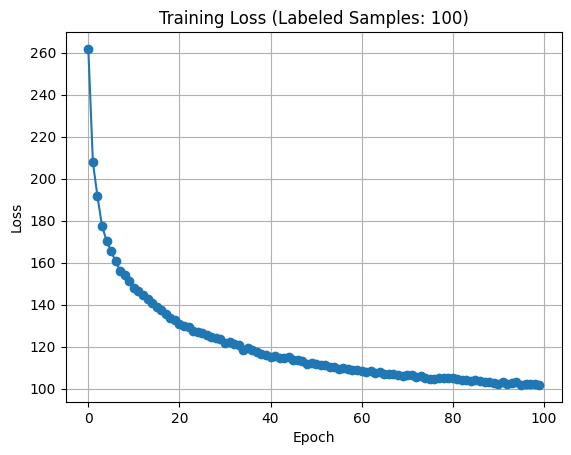

Test Accuracy (100 labels): 70.33%


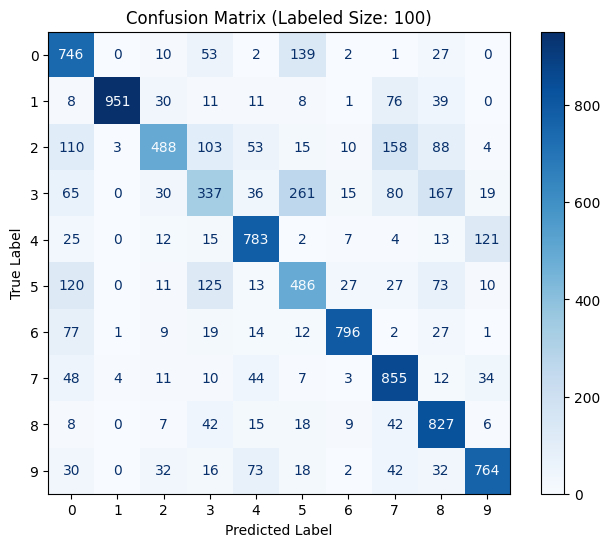

----------------------------------------------------------------
Starting training with 1000 labels and 59000 without labels...
Epoch [1/100], Average Loss: 251.1526
Epoch [2/100], Average Loss: 190.4027
Epoch [3/100], Average Loss: 166.4117
Epoch [4/100], Average Loss: 157.2461
Epoch [5/100], Average Loss: 151.0675
Epoch [6/100], Average Loss: 145.5588
Epoch [7/100], Average Loss: 141.3890
Epoch [8/100], Average Loss: 137.1749
Epoch [9/100], Average Loss: 134.4102
Epoch [10/100], Average Loss: 132.2657
Epoch [11/100], Average Loss: 129.7972
Epoch [12/100], Average Loss: 127.9549
Epoch [13/100], Average Loss: 125.8729
Epoch [14/100], Average Loss: 124.2207
Epoch [15/100], Average Loss: 122.7696
Epoch [16/100], Average Loss: 121.1895
Epoch [17/100], Average Loss: 119.8029
Epoch [18/100], Average Loss: 118.6286
Epoch [19/100], Average Loss: 117.4777
Epoch [20/100], Average Loss: 116.6537
Epoch [21/100], Average Loss: 115.4955
Epoch [22/100], Average Loss: 115.0205
Epoch [23/100], Average

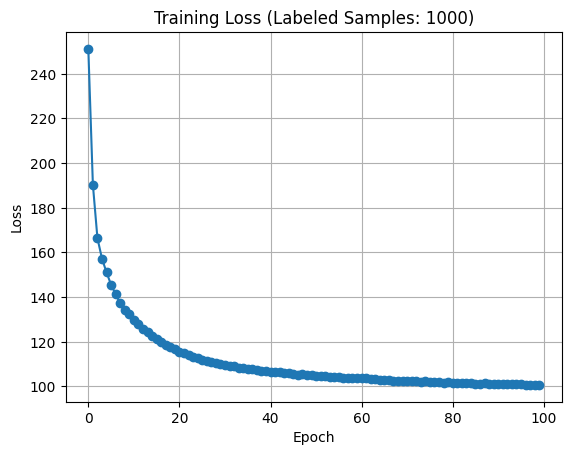

Test Accuracy (1000 labels): 92.29%


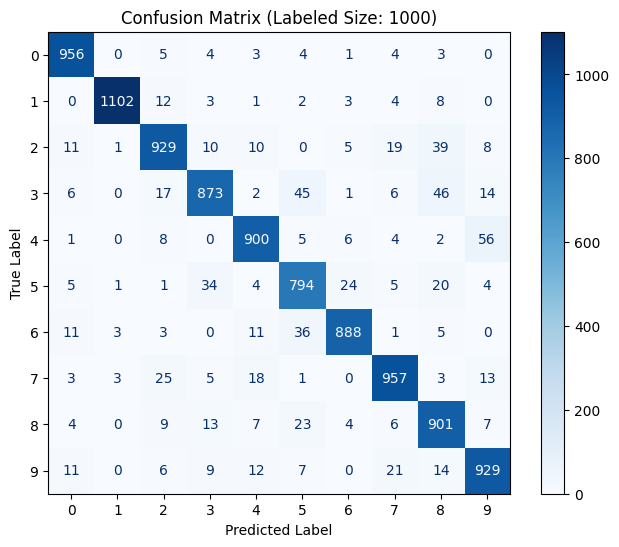

----------------------------------------------------------------
Starting training with 3000 labels and 57000 without labels...
Epoch [1/100], Average Loss: 246.4322
Epoch [2/100], Average Loss: 178.0450
Epoch [3/100], Average Loss: 158.3558
Epoch [4/100], Average Loss: 147.7341
Epoch [5/100], Average Loss: 140.5077
Epoch [6/100], Average Loss: 135.3830
Epoch [7/100], Average Loss: 131.3192
Epoch [8/100], Average Loss: 127.8983
Epoch [9/100], Average Loss: 125.1619
Epoch [10/100], Average Loss: 122.8817
Epoch [11/100], Average Loss: 120.7729
Epoch [12/100], Average Loss: 119.1645
Epoch [13/100], Average Loss: 117.7155
Epoch [14/100], Average Loss: 116.2999
Epoch [15/100], Average Loss: 115.2854
Epoch [16/100], Average Loss: 114.1950
Epoch [17/100], Average Loss: 113.2514
Epoch [18/100], Average Loss: 112.4272
Epoch [19/100], Average Loss: 111.6976
Epoch [20/100], Average Loss: 110.9648
Epoch [21/100], Average Loss: 110.5815
Epoch [22/100], Average Loss: 109.9395
Epoch [23/100], Average

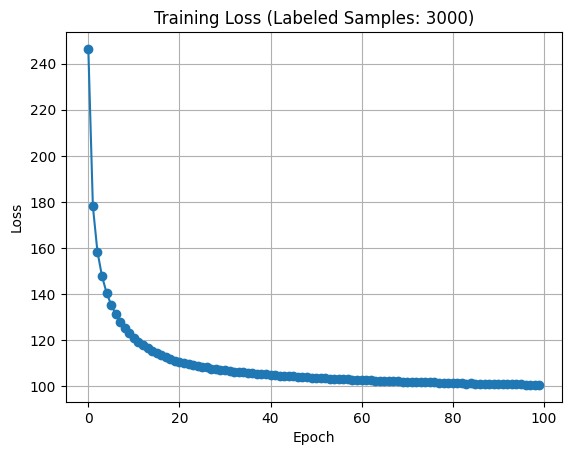

Test Accuracy (3000 labels): 94.78%


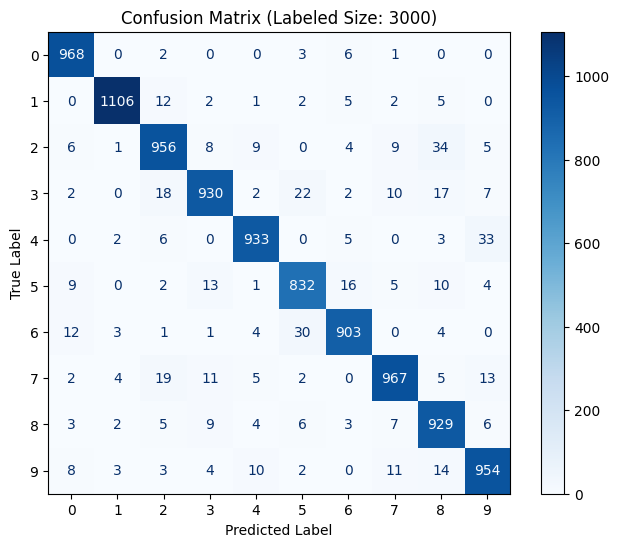

----------------------------------------------------------------


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters.
input_dim = 28 * 28  # MNIST images
hidden_dim = 256
latent_dim = 50
num_classes = 10
learning_rate = 1e-3
batch_size = 256
num_epochs = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

labels_list = [100, 1000, 3000] # Different label size

    # Create a semi-supervised split: We make the classes balanced in the supervised labels.

targets = train_dataset.targets
if not isinstance(targets, torch.Tensor):

    targets = torch.tensor(targets)

for labeled_size in labels_list:

    per_class = labeled_size // num_classes

    labeled_indices = []
    for c in range(num_classes):

        c_indices = (targets == c).nonzero(as_tuple=True)[0]

        c_indices = c_indices[torch.randperm(len(c_indices))]

        labeled_indices.extend(c_indices[:per_class].tolist())


    labeled_indices = set(labeled_indices)
    all_indices = set(range(len(train_dataset)))

    unlabeled_indices = list(all_indices - labeled_indices)
    labeled_indices = list(labeled_indices)

    labeled_dataset = Subset(train_dataset, labeled_indices)
    unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

    if labeled_size == 100:
        batch_size_labeled = 1
        batch_size = 599
    elif labeled_size == 1000:
        batch_size_labeled = 10
        batch_size = 590
    elif labeled_size == 3000:
        batch_size_labeled = 30
        batch_size = 570

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size_labeled, shuffle=True, pin_memory=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    model = SSL(input_dim, hidden_dim, latent_dim, num_classes, learning_rate)
    model = model.to(device)
    epoch_losses = []

    # Training loop
    print(f"Starting training with {labeled_size} labels and {len(train_dataset)-labeled_size} without labels...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        labeled_samples_count = 0
        unlabeled_samples_count = 0

        for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
            # Update counters
            num_batches += 1
            labeled_samples_count += x_l.size(0)
            unlabeled_samples_count += x_u.size(0)

            x_l = x_l.to(device)
            y_l = y_l.to(device)
            x_u = x_u.to(device)

            loss = model.train_step(x_l, y_l, x_u)
            total_loss += loss

        avg_loss = total_loss / (len(labeled_loader)+len(unlabeled_loader))
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
    print(f"  Processed {num_batches} batches: {labeled_samples_count} labeled samples, {unlabeled_samples_count} unlabeled samples")

    # Plot training loss curve
    plt.figure()
    plt.plot(epoch_losses, marker='o')
    plt.title(f'Training Loss (Labeled Samples: {labeled_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Evaluate on test data.
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            preds = model.predict(x)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
    print(f"Test Accuracy ({labeled_size} labels): {accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')

    ax.set_title(f'Confusion Matrix (Labeled Size: {labeled_size})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    print('----------------------------------------------------------------')




Generating latent space visualization...


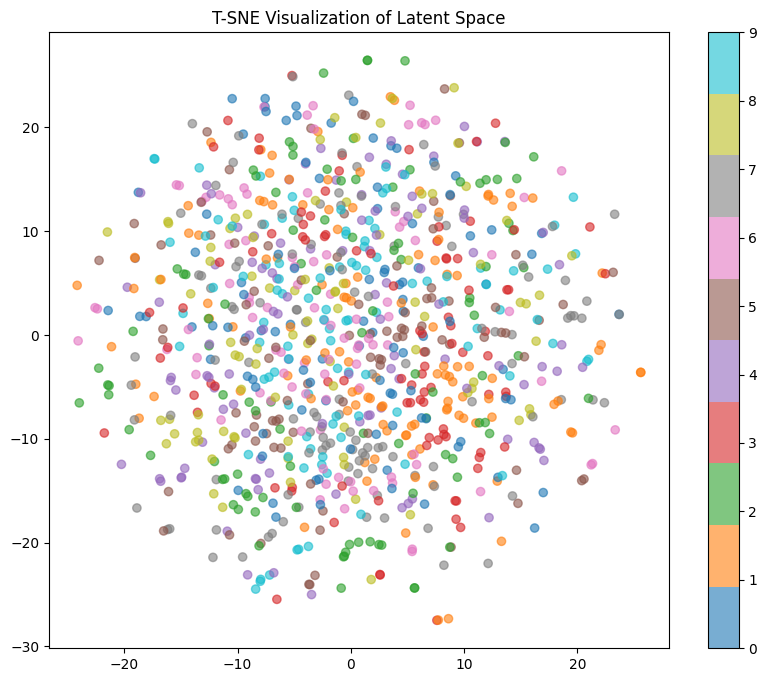

In [37]:
print("Generating latent space visualization...")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Create a data loader for the training dataset
model.visualize_latent_tsne(train_loader)  # Pass the data loader instead of the dataset

Generating latent space visualization...


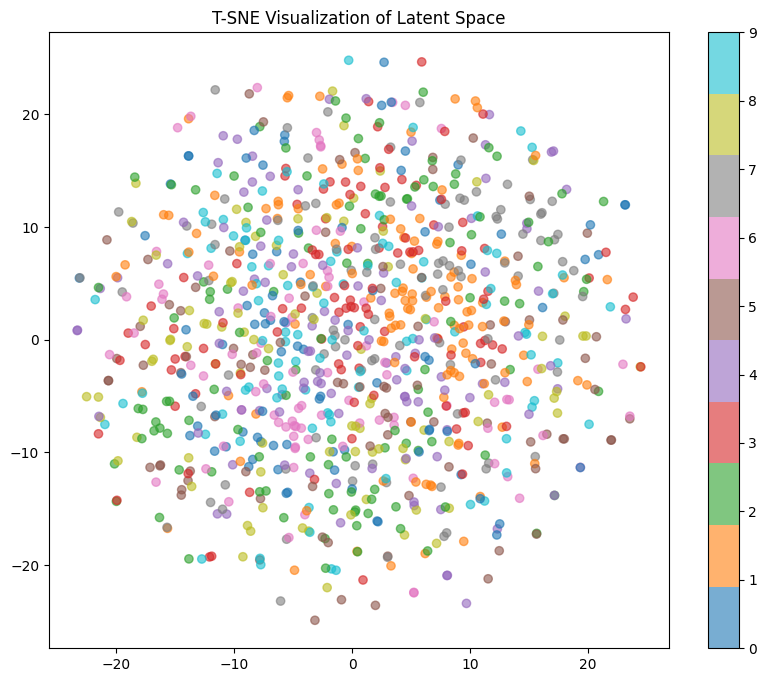

In [33]:
print("Generating latent space visualization...")
model.visualize_latent_tsne(test_loader)

Generating conditional samples...


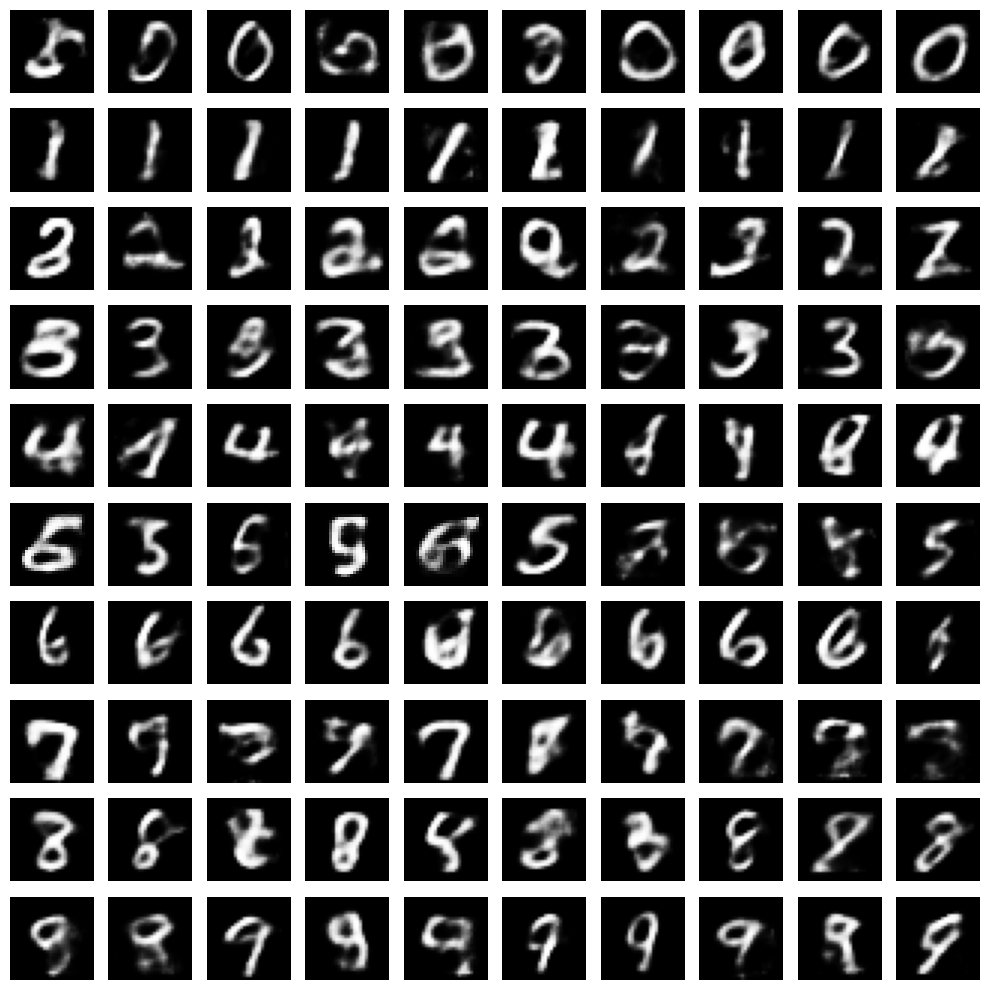

In [32]:
print("Generating conditional samples...")
model.generate_conditional_samples()